# Hamiltonian Monte Carlo Code


Write initial code for simple linear regression:

$$ y_i \sim N(\beta X_i, 1/\phi) $$
$$ \beta \sim N(0, 1/\tau) $$
$$ \phi \sim Gam(a, b) $$
Let $ \theta = (\beta, \phi) $

Initialize $\theta_0$: 

In [5]:
import scipy.stats as stats
import numpy as np

true_beta = stats.norm.rvs(1)
true_phi = stats.gamma.rvs(1)

x = stats.norm.rvs(size=20)
y = stats.norm.rvs(true_beta*x, 1/(true_phi)**(1/2))

beta0 = stats.norm.rvs(1)
phi0 = stats.gamma.rvs(4,4)
theta0 = np.array((beta0, phi0))

#Set hyperparameters
tau = 1/10
a = 1/2
b= 1/2


In [12]:
def leapfrog(theta, r, eps):
    n = y.shape[0]
    #gradients are specific to this example
    gradients = np.array((-tau * theta[0] + x.dot(y) - theta[0] * x.dot(x), (n/2 + a/2 -1)*1/theta[1] - b - 1/2* sum((y-theta[0]*x)**2)))
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd
    
        
def log_joint(y, x, theta):
    n = y.shape[0]
    #seems like this can be up to a normalizing constant so that's what i did, but otherwise that could be the issue
    return (n/2 + a -1)*np.log(theta[1]) - theta[1]*b -1/2 *(tau*theta[0]**2 + theta[1]*sum((y-theta[0]*x)**2))

def hamilt_mc(theta0, y,x, eps, L, M):
    theta_m = np.zeros((M,2))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=2)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog(theta_tilde, r_tilde, eps) 
        
        #need to deal with negative proposal values for phi (theta[1]) - doubt this is the correct way
        #seems to not be going in here .. so maybe it's fine
        if theta_tilde[1] < 0:
            print("reject")
            theta_tilde[1] = theta_m[m-1,1]
            accept_p -=1
        alpha = min(1, np.exp(log_joint(y,x, theta_tilde) - 1/2 * r_tilde.dot(r_tilde))/np.exp(log_joint(y,x, theta_m[m-1,:]) -1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m = - r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
            accept_b +=1
            accept_p +=1
    return(theta_m, accept_b, accept_p)

In [15]:
no_iters = 1000
results,acc_b, acc_p = hamilt_mc(theta0, y,x, 1/100, 100, no_iters)

#phi is off - but this seems to be working for beta
print("truth", (true_beta, true_phi))
print("we find", results[99,:])
print("acceptance (beta then phi)", acc_b/no_iters, acc_p/no_iters)

truth (1.9229227527351802, 0.4032763565923402)
we find [  1.99521505  16.4448378 ]
acceptance (beta then phi) 0.41 0.41


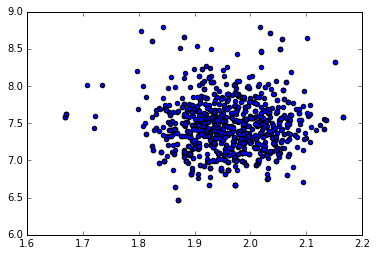

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(results[:,0], results[:,1])
plt.scatter

# Example for 250-dimensional multivariate normal (from paper)

In [122]:
#Known precision matrix A - df=250 with identity scale
A = stats.wishart.rvs(df=250, scale= np.eye(250))
#target distribution is zero-mean 250-dimensional multivariate normal with known precision

theta0 = stats.norm.rvs(size=250)

In [148]:
def leapfrog2(theta, A, r, eps):
    #gradients are specific to this example
    gradients = A.dot(theta)
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd
    
        
def log_joint2(theta, A):
    #seems like this can be up to a normalizing constant so that's what i did, but otherwise that could be the issue
    return -1/2 * theta.T.dot(A).dot(theta)

def hamilt_mc2(theta0, A, eps, L, M):
    no_par = theta0.shape[0]
    theta_m = np.zeros((M,no_par))
    theta_m[0,:] = theta0
    accept_th = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=no_par)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        #Leapfrog
        for i in range(L):
            theta_tilde, r_tilde = leapfrog2(theta_tilde, A, r_tilde, eps) #keeps pushing phi towards negative
        
        alpha = min(1, np.exp(log_joint2(theta_tilde,A) - 1/2 * r_tilde.dot(r_tilde))/np.exp(log_joint2(theta_m[m-1,:], A) -1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            accept_th += 1
            theta_m[m,:] = theta_tilde
            r_m = - r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
    return(theta_m, accept_th)


In [149]:
results, acc= hamilt_mc2(theta0, A, 1/10, 10, 1000)

print(acc) #getting weird runtime warning - may need to update this

999


/Users/elorenzi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in double_scalars
